Create database

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import engarde.decorators as ed

import toolbox.toolbox as tb

pd.set_option('display.max_colwidth', None)


data = 'Schweizer-Nährwertdatenbank-V6.1.xlsx'
foods = tb.read(data)


my_foods = {
    'avocado, roh': 'avocado',
    'blattsalat (durchschnitt), roh': 'lettuce',
    'champignon, roh': 'mushrooms',    
    'fleisch (durchschnitt exkl. innereien), roh': 'meat',
    'gemüse (durchschnitt), roh': 'vegetables',
    'hart- und halbhartkäse, vollfett (durchschnitt)': 'cheese',
    'hühnerei, ganz, festgekocht': 'eggs',
    'kakaopulver': 'cocoa powder', 
    'kochbutter': 'butter',
    'kokosfett': 'coconut fat',
    'kokosnuss, getrocknet (kokosrapseln, kokosflocken)': 'coconut flakes',
    'mandel': 'almond',
    'olivenöl': 'olive oil',
    'peperoni, rot, roh': 'red pepper',
    'poulet, schenkel, mit haut, gebraten (ohne zusatz von fett und salz)': 'chicken leg',
    'poulet, brust, schnitzel oder geschnetzeltes, gebraten (ohne zusatz von fett und salz)': 'chicken breast',
    'samen, kerne, nüsse (durchschnitt), ungesalzen': 'nuts and seed mix',
    'schwein, hals, steak, gebraten (ohne zusatz von fett und salz)': 'pork steak',
    'spinat, roh': 'spinach', 
    'tofu': 'tofu',
}

myfoods = tb.make_myfoods(foods, my_foods)
myfoods.info()



/Users/fgu/miniconda3/envs/basics/lib/python3.7/site-packages/engarde/checks.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 33 to 907
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       20 non-null     object 
 1   category   20 non-null     object 
 2   units      20 non-null     object 
 3   calories   20 non-null     int64  
 4   fat        20 non-null     float64
 5   carbs      20 non-null     float64
 6   fiber      20 non-null     float64
 7   protein    20 non-null     float64
 8   net_carbs  20 non-null     float64
dtypes: float64(5), int64(1), object(3)
memory usage: 1.6+ KB


Find items

In [2]:
tb.find_item(foods, 'hühnere')

,name,category,units,calories,fat,carbs,fiber,protein,net_carbs
315,"hühnerei, ganz, festgekocht",eier,pro 100g essbarer Anteil,157,11.4,0.3,0.0,13.2,0.3
316,"hühnerei, ganz, roh",eier,pro 100g essbarer Anteil,142,10.3,0.3,0.0,11.9,0.3
317,"hühnereigelb, roh (eidotter)",eier,pro 100g essbarer Anteil,350,31.5,0.2,0.0,16.5,0.2
318,"hühnereiweiss, roh (eiklar)",eier,pro 100g essbarer Anteil,44,0.1,0.3,0.0,10.5,0.3


Define meals

In [3]:
meals = {
    
    'breakfast': {
        'eggs': 2,
    },
    
    'lunch': {
        'lettuce': 2,
        'avocado': 1.5,
        'olive oil': .2,
        'red pepper': 1,
        'eggs': 2, 
        'nuts and seed mix': .5,
        'cheese': 0,
    },

    'supper': {
        'vegetables': 0,
        'avocado': 1.5,
        'butter': .2,
        'pork steak': 0,
        'cheese': 0
    }
}

Calc nuts for each meal and for day

In [4]:
def calc_nutrients(data, meal):
    
    nutrients = ['calories', 'fat', 'protein', 'net_carbs']
    
    data = data.loc[data.name.isin(meal), nutrients].sum()
        
    grams = data[1:].copy()
    grams['total'] = grams.sum()
    
    cals = data[1:].copy()
    cals['fat'] = grams.fat * 9
    cals['protein'] = grams.protein * 4
    cals['net_carbs'] = grams.net_carbs * 4
    cals['total'] = data['calories']
    
    nuts = pd.concat([grams, cals], axis=1)
    nuts = nuts.reindex(['total', 'fat', 'protein', 'net_carbs'])
    nuts[nuts < 0] = 0
    nuts.columns = ['grams', 'cals']
    
    return nuts

meal_nuts = {meal: calc_nutrients(myfoods, meals[meal]) for meal in meals}
meal_nuts['total'] = sum([meal_nuts[meal] for meal in meal_nuts])

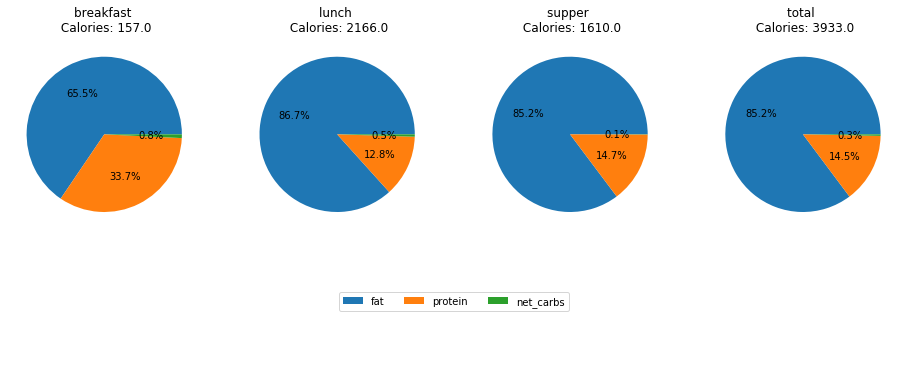

In [11]:
def make_dashboard(meals):

    def make_doughnut(data, axis, meal_name):
        meal_name = 
        total_cals = data.loc['total', 'cals']
        nuts = data[1:]
        
        ax[axis].pie(nuts.cals, autopct='%2.1f%%')
        ax[axis].set_title(f"{meal_name} \n Calories: {total_cals}")
        
    fig, ax = plt.subplots(1, len(meals), figsize=(16, 8))

    for meal_num, meal_name in enumerate(meals):
        make_doughnut(meals[meal_name], meal_num, meal_name)

    fig.legend(['fat', 'protein', 'net_carbs'], 
               loc='lower center', 
               borderaxespad=6, ncol=3);
    
make_dashboard(meal_nuts)